# Quickstart

This notebook shows how to train and validate a model with ScAPE and how to do predictions for cell/drug combinations

In [1]:
# Disable all warnings
import scape
import pandas as pd
import matplotlib.pyplot as plt

scape.__version__

'0.1.0'

In [2]:
df_de = scape.io.load_slogpvals("_data/de_train.parquet")
df_lfc = scape.io.load_lfc("_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

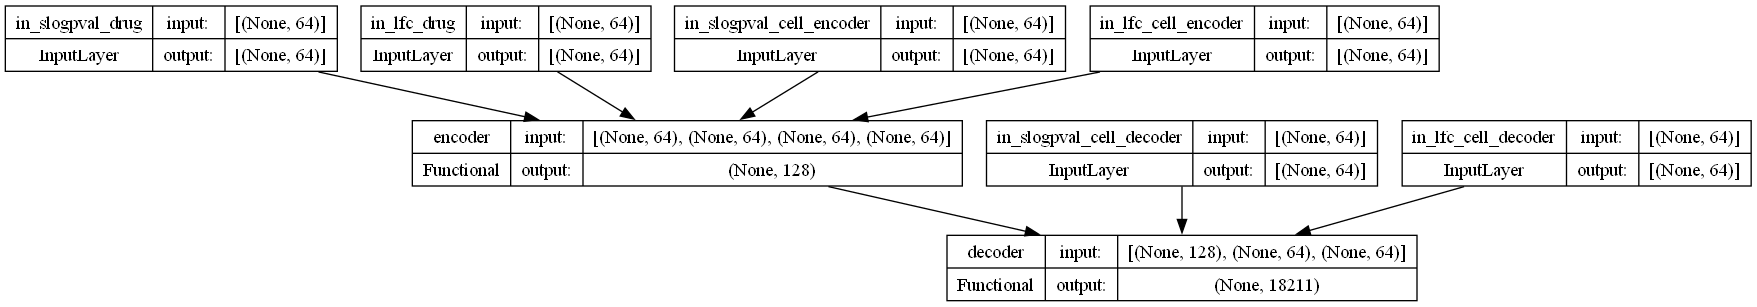

In [3]:
# We select only a subset of the genes for the model (top most variant genes)
n_genes = 64
top_genes = scape.util.select_top_variable([df_de], k=n_genes)

# Data sources point to the dataframes with the data from which the features are extracted
data_sources = {
    'slogpval': df_de,
    'lfc_pseudo': df_lfc
}

# Define the way in which the features are extracted from the data sources
feature_extraction = {
    'slogpval_drug': {
        'source': 'slogpval',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'lfc_drug': {
        'source': 'lfc_pseudo',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'slogpval_cell': {
        'source': 'slogpval',
        'groupby': 'cell_type',
        'function': 'median'
    },
    'lfc_cell': {
        'source': 'lfc_pseudo',
        'groupby': 'cell_type',
        'function': 'median'
    }
}

# Names of the input layers -> feature extraction method
input_mapping = {
    'in_slogpval_drug': 'slogpval_drug',
    'in_lfc_drug': 'lfc_drug',
    'in_slogpval_cell_encoder': 'slogpval_cell',
    'in_lfc_cell_encoder': 'lfc_cell',
    'in_slogpval_cell_decoder': 'slogpval_cell',
    'in_lfc_cell_decoder': 'lfc_cell',
}

# Configuration for the NN architecture
config = {
    "inputs": {
        "in_slogpval_drug"          : [n_genes, 256, 128],
        "in_lfc_drug"               : [n_genes, 256, 128],
    },
    "conditional_encoder_input_structure": {
        "in_slogpval_cell_encoder"  : [n_genes, 32],
        "in_lfc_cell_encoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_structure": {
        "in_slogpval_cell_decoder"  : [n_genes, 32],
        "in_lfc_cell_decoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_hidden_sizes": [32],
    "encoder_hidden_layer_sizes": [128, 128],
    "decoder_hidden_layer_sizes": [128, 512],
    "outputs": {
        "logpval": (df_de.shape[1], "linear"), 
    },
    # Layer config
    "noise": 0.01,
    "dropout": 0.05,
    "l1": 0,
    "l2": 0
}

model_setup = {
    "data_sources": data_sources,
    "feature_extraction": feature_extraction,
    "input_mapping": input_mapping,
    "output_genes": df_de.columns,
    "config": config
}

# Create model
scm = scape.SCAPE(model_setup)
scape.util.plot(scm.model, show_shapes=True)

In [4]:
scm.model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_slogpval_drug (InputLay  [(None, 64)]                 0         []                            
 er)                                                                                              
                                                                                                  
 in_lfc_drug (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 in_slogpval_cell_encoder (  [(None, 64)]                 0         []                            
 InputLayer)                                                                                      
                                                                                        

In [5]:
result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=300,
    baselines=["zero", "slogpval_drug"]
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']

Epoch    1: val_loss None -> 1.4130, train loss: 1.3069 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0101, 1.00%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7981, -25.30%
Epoch    2: val_loss 1.4130 -> 1.3710, train loss: 1.2787 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0410, 3.94%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8226, -21.57%
Epoch    3: val_loss 1.3710 -> 1.3521, train loss: 1.2551 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0556, 5.27%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8341, -19.89%
Epoch    8: val_loss 1.3521 -> 1.3280, tra

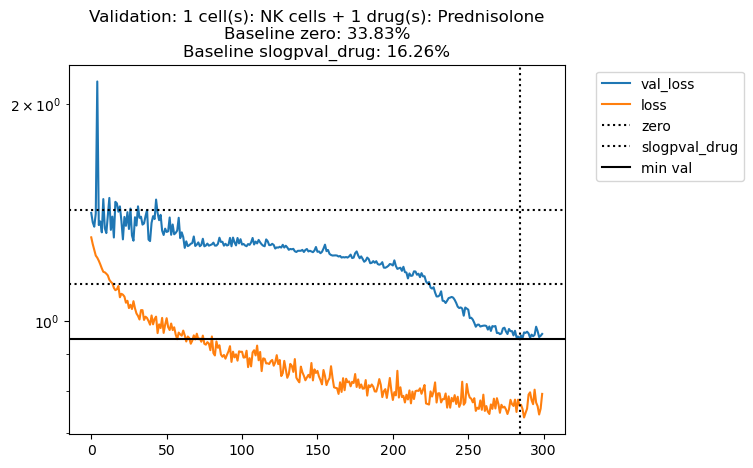

In [6]:
scape.util.plot_result(result, legend=True)

## Inference

In [7]:
# Predict using a given dataframe index
scm.predict(df_de)

20/20 [==============================] - 1s 8ms/step


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.294561,0.170899,0.024917,0.186277,0.294101,0.599160,0.033555,0.214552,-0.181520,0.238170,...,0.031728,-0.140401,0.013802,0.061156,0.068306,0.170278,0.171808,0.141375,0.030203,0.077878
T cells CD4+,Clotrimazole,0.079339,0.036201,0.242395,0.042650,0.156384,0.432905,-0.130829,0.153731,-0.080531,0.179721,...,-0.211244,0.063654,0.106261,0.035484,0.367466,0.015294,0.270747,0.084104,0.158804,-0.034223
T cells CD8+,Clotrimazole,-0.099290,-0.378547,-0.185654,-0.006682,-0.032257,-0.294652,-0.142150,-0.178801,-0.402240,0.231307,...,-0.006893,-0.365033,-0.333244,-0.440647,-0.013950,-0.271347,0.087105,-0.115613,-0.070332,-0.186203
T regulatory cells,Clotrimazole,0.360593,0.264383,0.542052,0.703738,0.608042,0.605393,-0.092830,0.343233,-0.126141,0.157045,...,-0.035292,0.346921,0.064953,0.233044,0.486937,0.515514,0.426341,0.323860,-0.100992,-0.003615
NK cells,Mometasone Furoate,1.174572,-0.229621,-0.220865,-0.353072,0.540341,1.433486,0.344411,0.823353,-0.132841,2.111995,...,-0.121811,-0.276259,0.401239,0.001112,0.109617,0.416923,0.206982,0.410168,-1.388913,0.596316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T regulatory cells,Atorvastatin,0.054876,-0.170694,-0.088170,-0.189913,-0.204570,-0.063881,-0.117282,-0.427712,-0.125835,0.026969,...,-0.235374,-0.291610,-0.236944,-0.360256,-0.150360,0.100144,-0.092555,-0.061963,-0.016585,-0.278647
NK cells,Riociguat,0.111024,0.221166,0.063734,0.075640,0.187435,0.290698,0.023857,0.209563,-0.211794,0.029293,...,0.090363,-0.096948,-0.098575,0.055208,-0.023532,0.124960,0.130364,0.039166,0.048087,-0.013087
T cells CD4+,Riociguat,0.132398,0.047667,0.215235,-0.082995,0.057747,0.254580,-0.109197,0.131442,0.042204,0.024869,...,-0.058043,0.093110,0.048425,0.160144,0.361891,0.105455,0.183357,-0.025409,0.161738,-0.027084


In [8]:
# Predict from a given multi-index
scm.predict(
    pd.MultiIndex.from_tuples([
        ("NK cells", "Bosutinib"),
        ("NK cells", "Belinostat"),
        ("Myeloid cells", "Bosutinib"),
        ("Myeloid cells", "Belinostat"),
    ], names=["cell_type", "sm_name"])
)

1/1 [==============================] - 0s 74ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1      A2MP1  \
cell_type     sm_name                                                           
NK cells      Bosutinib   0.439439  0.148229  -0.101199   0.186942   0.375670   
              Belinostat  2.612220  3.465668 -10.117694 -18.421534  -4.458287   
Myeloid cells Bosutinib   0.521007 -0.007736   0.102343   0.155096   4.031403   
              Belinostat  3.326534  3.086952 -10.404086  -1.008761  14.360516   

                            A4GALT      AAAS      AACS     AAGAB      AAK1  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.906213  0.101044  0.241807 -0.148498  0.332720   
              Belinostat  8.614016  1.336878  0.885975  5.295789  5.883156   
Myeloid cells Bosutinib   2.074997  0.131581  0.085806  0.280848  0.382285   
              Belinostat  3.828290  0.912709 -1.312202  2.158703  5.711684   

                          ...      ZUP1      ZW10    ZWILCH     ZWINT  \
cell_type     sm_name     ...                                           
NK cells      Bosutinib   ...  0.042326 -0.181594  0.067935  0.056654   
              Belinostat  ...  6.119287  2.129124 -2.373105  1.404278   
Myeloid cells Bosutinib   ... -1.007390 -0.500698 -0.265565 -0.994533   
              Belinostat  ...  2.886196  0.172230 -9.051595 -2.524220   

                              ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.091547  0.206323  0.214362  0.171329  0.011553   
              Belinostat -0.688431  0.633955 -1.306625  4.053644 -0.637683   
Myeloid cells Bosutinib   0.858484  0.062378 -0.244070  0.204969 -0.268329   
              Belinostat  0.805234 -1.857426 -4.270396  1.194274  1.879652   

                             ZZEF1  
cell_type     sm_name               
NK cells      Bosutinib   0.154529  
              Belinostat -1.382961  
Myeloid cells Bosutinib  -0.060159  
              Belinostat  0.171560  

[4 rows x 18211 columns]

In [9]:
# Predict from tuples
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 [==============================] - 0s 44ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                          
NK cells  Bosutinib   0.439439  0.148229  -0.101199   0.186942  0.375670   
          Belinostat  2.612220  3.465668 -10.117694 -18.421534 -4.458287   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.906213  0.101044  0.241807 -0.148498  0.332720  ...   
          Belinostat  8.614016  1.336878  0.885975  5.295789  5.883156  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib   0.042326 -0.181594  0.067935  0.056654  0.091547   
          Belinostat  6.119287  2.129124 -2.373105  1.404278 -0.688431   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.206323  0.214362  0.171329  0.011553  0.154529  
          Belinostat  0.633955 -1.306625  4.053644 -0.637683 -1.382961  

[2 rows x 18211 columns]

1/1 [==============================] - 0s 56ms/step


<Axes: xlabel='y', ylabel='y_pred'>

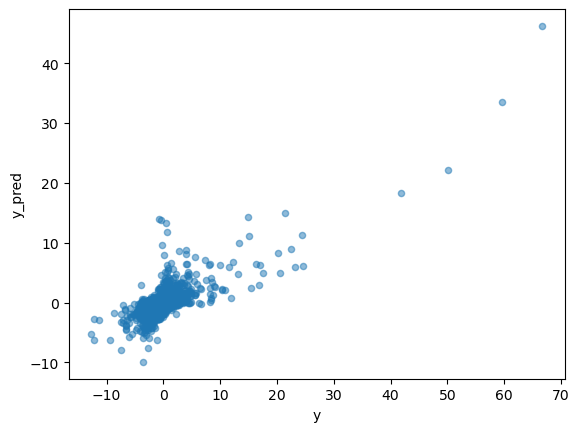

In [10]:
# Plot correlation between predicted and observed values
df_cmp = pd.DataFrame({
    'y': df_de.loc[("NK cells", "Prednisolone")].values.ravel(), 
    'y_pred': scm.predict([("NK cells", "Prednisolone")]).values.ravel()
})

# Make the plot square with same X and Y limits
df_cmp.plot.scatter(x='y', y='y_pred', alpha=0.5)